In [73]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# fetch dataset 
credit_approval = fetch_ucirepo(id=27) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 

#создаем датафрейм в удобном для нас формате pandas
df = pd.DataFrame(data=credit_approval.data.features, columns=credit_approval.variables.name)
#столбец A16 - таргет ("выдан займ или нет"), его нам дали в виде столбца со строками '+' и "-", поэтому для дальнейщего упрощения сразу заменим эти значения на 1 и 0 соответственно
df['A16']= y
df['A16'] = df["A16"].replace({"+": 1, "-": 0})

#выведем пять первых строк нашего датафрейма, чтобы примерно понимать, как выглядят наши данные
df.head()


name,A16,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1
0,1,0,202.0,g,f,1,t,t,1.25,v,w,g,u,0.000,30.83,b
1,1,560,43.0,g,f,6,t,t,3.04,h,q,g,u,4.460,58.67,a
2,1,824,280.0,g,f,0,f,t,1.50,h,q,g,u,0.500,24.50,a
3,1,3,100.0,g,t,5,t,t,3.75,v,w,g,u,1.540,27.83,b
4,1,0,120.0,s,f,0,f,t,1.71,v,w,g,u,5.625,20.17,b


## EDA -  exploratory data analysis ##



Непрерывные переменные представляют собой данные, которые могут принимать любые числовые значения в определенном диапазоне.
Категориальные переменные по определению могут принимать только ограниченное и обычно фиксированное количество возможных значений.

Эти свойства понадобятся нам при заполнении пропусков.
Так же категориальные переменные в данном датафрейме принимают только буквенные значения.

In [75]:
# variable information 


# для удобства разделим переменные на категориальные и непрерывные
# сразу же дропнем переменную A16, так как она таргетная (поэтому срез с 1-ой строки)
continuous = credit_approval.variables[1:][credit_approval.variables[1:]['type']=='Continuous']
categorical = credit_approval.variables[1:][credit_approval.variables[1:]['type']=='Categorical']

In [76]:
continuous

,name,role,type,demographic,description,units,missing_values
1,A15,Feature,Continuous,None,None,None,no
2,A14,Feature,Continuous,None,None,None,yes
5,A11,Feature,Continuous,None,None,None,no
8,A8,Feature,Continuous,None,None,None,no
13,A3,Feature,Continuous,None,None,None,no
14,A2,Feature,Continuous,None,None,None,yes


In [77]:
categorical


,name,role,type,demographic,description,units,missing_values
3,A13,Feature,Categorical,None,None,None,no
4,A12,Feature,Categorical,None,None,None,no
6,A10,Feature,Categorical,None,None,None,no
7,A9,Feature,Categorical,None,None,None,no
9,A7,Feature,Categorical,None,None,None,yes
10,A6,Feature,Categorical,None,None,None,yes
11,A5,Feature,Categorical,None,None,None,yes
12,A4,Feature,Categorical,None,None,None,yes
15,A1,Feature,Categorical,None,None,None,yes


In [78]:
# Заполним пропуски, а так же проиллюстрируем их заполнение:
# для начала в таблицу started_blanks запишем количество пропусков в каждом столбце
started_blanks = df.isna().sum()
# непосредственно заполним пропуски
for name in credit_approval.variables.name[1:]:
    if (df[name].isna().sum()!=0):
        if ((df[name].dtype == int) or (df[name].dtype == float)): 
            # если в столбце не строки, а числа, то заполним средним значением (если переменные непрерывные)
            fill_value = df[name].mean()
            df[name].fillna(fill_value, inplace=True)
        else:
            # если переменная категориальная, то по свойству, описанному выше, кажется логичным заполнить пропуски самым популярным значением в столбце
            counted_values = df[name].value_counts()
            most_common =counted_values.idxmax()
            df[name].fillna(most_common, inplace=True)
            
# создадим еще одну таблицу с количеством пропусков, но уже в заполненном датафрейме
finished_blanks = df.isna().sum()

print("До заполнения:")
print(started_blanks)
print("")
print("После заполнения:")
print(finished_blanks)

До заполнения:
name
A16     0
A15     0
A14    13
A13     0
A12     0
A11     0
A10     0
A9      0
A8      0
A7      9
A6      9
A5      6
A4      6
A3      0
A2     12
A1     12
dtype: int64

После заполнения:
name
A16    0
A15    0
A14    0
A13    0
A12    0
A11    0
A10    0
A9     0
A8     0
A7     0
A6     0
A5     0
A4     0
A3     0
A2     0
A1     0
dtype: int64


Теперь изучим распределение переменных в столбцах, где каждый элемент - числовое значение. Иными словами, рассмотрим распределение непрерывных переменных:

Для начала выведем основную информацию о столбцах с непрерывными переменными

In [79]:
df.describe()
# count - The number of not-empty values.
# mean - The average (mean) value.
# std - The standard deviation.
# min - the minimum value.
# 25% - The 25% percentile*.
# 50% - The 50% percentile*.
# 75% - The 75% percentile*.
# max - the maximum value.

name,A16,A15,A14,A11,A8,A3,A2
count,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000
mean,0.444928,1017.385507,184.014771,2.40000,2.223406,4.758725,31.568171
std,0.497318,5210.102598,172.159274,4.86294,3.346513,4.978163,11.853273
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,13.750000
25%,0.000000,0.000000,80.000000,0.00000,0.165000,1.000000,22.670000
50%,0.000000,5.000000,160.000000,0.00000,1.000000,2.750000,28.625000
75%,1.000000,395.500000,272.000000,3.00000,2.625000,7.207500,37.707500
max,1.000000,100000.000000,2000.000000,67.00000,28.500000,28.000000,80.250000


In [80]:
warnings.filterwarnings("ignore")
updatemenu = [dict()]
buttons = []
fig = go.Figure()
data =[]
for i in continuous.name:
    trace = px.histogram(df[i]).data[0]
    trace.visible = False
    data.append(trace) 
fig.add_traces(data) 

for i, col in enumerate(continuous.name):

    visibles = [False] * len(continuous.name)
    visibles[i] = True
    buttons.append(dict(method='restyle',
                        label=col,
                        args=["visible", visibles]
                        ))

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

fig.update_layout(showlegend=True, updatemenus=updatemenu)
fig.update_layout(
     title={
        "text": "Распределение непрерывных переменных",
        "x": 0.5
    },
    xaxis_title="Диапазон",
    yaxis_title="Количество значений"
)
fig.show()
warnings.filterwarnings("default")

Теперь рассмотрим распределение категориальных переменных

In [81]:
warnings.filterwarnings("ignore")
updatemenu = [dict()]
buttons = []
fig2 = go.Figure()

data =[]
for i in categorical.name[1:]:
    trace = px.histogram(df[i]).data[0]
    trace.visible = False
    data.append(trace) 
fig2.add_traces(data) 

for i, col in enumerate(categorical.name):

    visibles = [False] * len(categorical.name)
    visibles[i] = True
    buttons.append(dict(method='restyle',
                        label=col,
                        args=["visible", visibles]
                        ))

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

fig2.update_layout(showlegend=True, updatemenus=updatemenu)
fig2.update_layout(
     title={
        "text": "Распределение категориальных переменных",
        "x": 0.5
    },
    xaxis_title="Значение",
    yaxis_title="Количество значений"
)
fig2.show()
warnings.filterwarnings("default")


Также необходимо посмотреть на корреляцию непрерывных переменных

In [82]:
df.corr()

name,A16,A15,A14,A11,A8,A3,A2
name,,,,,,,
A16,1.000000,0.175657,-0.099972,0.406410,0.322475,0.206294,0.161627
A15,0.175657,1.000000,0.065609,0.063692,0.051345,0.123121,0.018539
A14,-0.099972,0.065609,1.000000,-0.119809,-0.076389,-0.222346,-0.077161
A11,0.406410,0.063692,-0.119809,1.000000,0.322330,0.271207,0.185575
A8,0.322475,0.051345,-0.076389,0.322330,1.000000,0.298902,0.392787
A3,0.206294,0.123121,-0.222346,0.271207,0.298902,1.000000,0.201316
A2,0.161627,0.018539,-0.077161,0.185575,0.392787,0.201316,1.000000


In [83]:
warnings.filterwarnings("ignore")
fig_cor = px.imshow(df.corr(), text_auto=True)
fig_cor.update_layout(
     title={
        "text": "Корреляция непрерывных переменных",
        "x": 0.5
    },

)
fig_cor.show()
warnings.filterwarnings("default")

Теперь поработаем с категориальными признаками. 

Очевидно, работать с некоторым дискретным набором строковых значений неудобно для анализа, поиска зависимостей и построения гипотез. В этом случае нас выручит метод преобразования категориальных столбцов в столбцы, где каждому из принимаемых признаком значений соответсвует единственная цифра.

Например, если у нас были признаки A1, A2, что содержали наборы значений из словаря {"a", "b", "c"}:

$$\begin{array}{cc}
A1 & A2 \\
a & b \\
c & a \\
b & c \\
a & b \\
\end{array}$$

то в измененном датафрейме при создании фиктивных переменных мы получим признаки $A1$, $A2$

$$\begin{array}{cc}
A1 & A2 \\
1 & 2 \\
3 & 1 \\
2 & 3 \\
1 & 2 \\
\end{array}$$

Возьмём признаки из списка "categorical":

In [84]:
categorical.name

3     A13
4     A12
6     A10
7      A9
9      A7
10     A6
11     A5
12     A4
15     A1
Name: name, dtype: object

In [85]:
%pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [86]:
import category_encoders as ce

encoder = ce.OrdinalEncoder(cols=categorical.name)
df = encoder.fit_transform(df)
#уберем из дата фрейма нашу таргетную переменную - A16
target = df['A16']
df = df.drop(["A16"], axis = 1)
#таргетную переменную тоже преобразуем в числа (0 и 1), так как нам этот столбец дан в формате строк


Проведём небольшой EDA с фиктивными переменными. Для начала, исследуем корреляцию:

In [87]:
warnings.filterwarnings("ignore")
fig_cor = px.imshow(df.corr(), text_auto=True)
fig_cor.update_layout(
     title={
        "text": "Корреляция фиктивных переменных, представляющих категориальные",
        "x": 0.5
    },

)
fig_cor.show()
warnings.filterwarnings("default")


In [88]:
df.describe()

name,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1
count,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000
mean,1017.385507,184.014771,1.105797,1.457971,2.40000,1.572464,1.476812,2.223406,1.847826,6.960870,1.242029,1.242029,4.758725,31.568171,1.304348
std,5210.102598,172.159274,0.343458,0.498592,4.86294,0.495080,0.499824,3.346513,1.395110,3.802822,0.435342,0.435342,4.978163,11.853273,0.460464
min,0.000000,0.000000,1.000000,1.000000,0.00000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,13.750000,1.000000
25%,0.000000,80.000000,1.000000,1.000000,0.00000,1.000000,1.000000,0.165000,1.000000,3.000000,1.000000,1.000000,1.000000,22.670000,1.000000
50%,5.000000,160.000000,1.000000,1.000000,0.00000,2.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,2.750000,28.625000,1.000000
75%,395.500000,272.000000,1.000000,2.000000,3.00000,2.000000,2.000000,2.625000,2.000000,10.000000,1.000000,1.000000,7.207500,37.707500,2.000000
max,100000.000000,2000.000000,3.000000,2.000000,67.00000,2.000000,2.000000,28.500000,9.000000,14.000000,3.000000,3.000000,28.000000,80.250000,2.000000


Разделим нашу выборку на тестовую и валидационную

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)


## Постановка задачи ##


Наш датасэт представляет собой данные об одобрении заявление на получение кредитных карт. Иными словами, на вход поступает вектор признаков, на основе которых банк выдает категориальный ответ: "одобрено" или "неодобрено".

Для банка важно с хорошей точностью определять добросовестных и недобросовестных заемщиков, чтобы не допустить как большой доли упущенной выгоды (в случае, если откажут хорошему заемщику), так и больших потерь (слишком много одобренных кредитов, которые потом не возвращаются).

Наша цель: по вектору признаков с хорошей точностью классифицировать "хороших" и "плохих" заемщиков.

## Методы оценивания ##
В нашей работе основными инструментами оценивания точности модели будут показатели, получаемые из  *Матрицы ошибок*.
Для начала объясним структуру матрицы ошибок:

![](https://i.ibb.co/C88Tvps/metrix1.png)

**Пусть:**

0 — объекты относятся к нулевому классу, (в нашей модели - отказ в выдаче займа)

1 — объекты относятся к классу 1 (в нашей задаче - одобренный займ).


**Матрица ошибок** - матрица, в нашем случае размера 2 на 2, такая что столбцы означают то, к какому классу объект относится в реальности, а строки - к какому признаку относится объект по прогнозу модели. В ячейках на пересечении обычно записываются числа, означающие количество объектов на валидационной выборке с одной из 4 возможных комбинаций. 


**С помощью матрицы ошибок мы можем ввести несколько следующих метрик:**


**Accuracy:** $(TP + TN)/(TP + TN + FP + FN)$ -- доля исходов, которую наша модель определила правильно

**Precision:** $TP/ (TP + FP)$ -- какая доля от предсказанных объектов класса 1 и в реальности является объектом класса 1.

**Recall:** $TP / (TP + FN)$ -- какая доля от тех значений, которые в  реальности должны относится к классу 1, были правильно определены моделью.


**Иными словами, в условиях нашей задачи:**

**Precision** - сколько мы выдали кредитов тем людям, которым должны были выдать в реальности. Тут учитывается, что, мы могли выдать кредиты тем, кто в последствии будет недобросовестным заемщиком (то есть в реальности принадлежит классу 0). Из-за этого банк может понести убытки

**Recall** - сколько мы выдали кредитов тем, кто должен был их получить, с учетом того, что мы отсеяли какую-то часть добросовестных заемщиков (представителей класса 1) и как банк упустили выгоду. Recall - способность нашей модели определять класс 1.

Для  банка важнее максимизировать  Precision , так как это поможет избежать больших убытков в случае, если модель будет выдавать слишком много займов недобросовестным заемщикам (слишком большое число FP)


## Тестирование разных моделей машинного обучения ##

Начнём играться с различными моделями машинного обучения.

## Рассмотрим самую простую модель - линейной регрессии:

Стоит сразу заметить и обозначить, что линейная регрессия не является наилучшим выбором для задачи кредитного скоринга, поскольку она предназначена для решения задачи регрессии (предсказание непрерывного числового значения), в то время как задача кредитного скоринга является задачей классификации (предсказание бинарного результата: одобрение кредита или отказ).

Мы же рассмотрим эту обучим эту модель для примера и небольшого анализа её работы. Кроме того, познакомим читателя с базовой структурой рассмотрения модели, включая вывод матрицы ошибок.

In [90]:
# создание модели линейной регрессии
model = LinearRegression()

# обучение модели
model.fit(X_train, y_train)

# получение прогнозов
y_pred = model.predict(X_test)

# оценка качества модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# вывод результатов
print(f"Среднеквадратичная ошибка (MSE): {mse}")
print(f"Коэффициент детерминации (R^2): {r2}")

print("")

# получение коэффициентов регрессии
coefficients = pd.DataFrame({'Признак': X_train.columns, 'Коэффициент': model.coef_})
print(coefficients)

Среднеквадратичная ошибка (MSE): 0.13458523569804262
Коэффициент детерминации (R^2): 0.4615459603711085

   Признак  Коэффициент
0      A15     0.000014
1      A14    -0.000063
2      A13     0.066686
3      A12    -0.028628
4      A11     0.007701
5      A10    -0.117320
6       A9    -0.610784
7       A8     0.007935
8       A7    -0.005002
9       A6    -0.007314
10      A5    -0.031922
11      A4    -0.031922
12      A3    -0.002642
13      A2     0.001461
14      A1     0.025642


Как мы уже договорились выше, линейная регрессия получила в y_pred набор некоторых действительных числовых значений. Так как в валидационной выборке y_train для каждого набора значений переменных лишь 0 или 1 (выдан кредит или нет), то и значение эти самые значения в y_pred должны жить в отрезке от нуля до единицы (либо, во всяком случае, если превосходить по модулю единицу, то не сильно)

Тогда, заменим значения в y_pred на единицу в случае, если они ближе к ней, чем к нулю, и наоборот.


In [91]:
threshold = 0.5

# создание массива с замененными значениями
y_pred_new = np.where(y_pred < threshold, 0, 1)

# посмотрим срез из 5 элементов в старом и новом массивах, а также на типы данных, содержащихся в них
print(y_pred[:5])
print(y_pred.dtype)
print("")
print(y_pred_new[:5])
print(y_pred_new.dtype)

[0.11550812 0.64222475 0.03047043 0.04802423 0.00371144]
float64

[0 1 0 0 0]
int64


Проиллюстрируем работу модели линейной регрессии через матрицу ошибок:

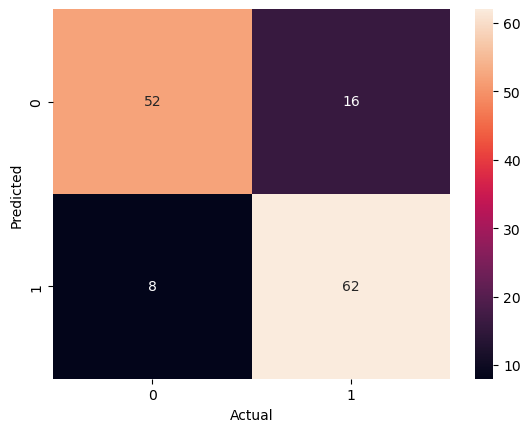

In [92]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred_new)

warnings.filterwarnings("ignore")
fig_mis = px.imshow(cm, text_auto=True)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
warnings.filterwarnings("default")

In [93]:
print('accuracy_score= {:.3f}'.format(accuracy_score(y_test, y_pred_new)))
print('recall_score = {:.3f}'.format(recall_score(y_test, y_pred_new)))
print('precision_score = {:.3f}'.format(precision_score(y_test, y_pred_new)))

accuracy_score= 0.826
recall_score = 0.886
precision_score = 0.795


Заметим, что в теории, возможно перебрать значения threshold так, чтобы приблизиться к логике принятия решений в банке. За этим стоит следующая логика - положим, что у банка есть некоторый действительный числовой рейтинг потенциального заемщика, который хранится в y_pred. Так как принятие решения о выдаче или невыдаче кредита влечёт крупные риски, которые описывались нами выше, то и банк вероятно не будет выдавать кредит заемщику с рейтингом около среднего или чуть выше него. 

Однако кроме того, что это с высокой вероятностью приведёт к переобучению, мы слишком заигрались с линейной регрессией - пора переходить к следующим моделям.

### Теперь рассмотрим модель логистической регрессии:

Логистическая регрессия - это статистический метод машинного обучения, который используется для моделирования вероятности бинарного (в данном случае) события в зависимости от некоторых признаков. В данном случае она будет являться методом классификации, который применяется для прогнозирования вероятности принадлежности объекта к одному из двух классов (например, "1" или "0").

Переформулировав модель на язык задачи кредитного скоринга, мы можем сказать, что логистическая регрессия в контексте кредитного скоринга используется для определения вероятности того, будет ли заявителю выдан кредит (класс "1") или не будет (класс "0") на основе различных признаков и их влияния на решение банка.

Как и в практически любой модели машинного обучения, у логистической регрессии есть ряд так называемых гиперпараметров (это параметры самой модели, задаваемые до обучения).
В частности, для достижения наилучшей точности, мы можем работать с

гиперпараметрами регуляризации (те, что, говоря простым языком, боряются с переобучением), например "penalty" (тип регуляризации) и "c" (обратное значение коэффициента регуляризации);

с гиперпараметрами оптимизации алгоритма - max_iter (максимальное количество итераций алгоритма - по умолчанию равен 100 для логистической регресси в sklearn), solver (важный параметр, фиксирующий сам алгоритм оптимизации);

а также некоторые другие, которые мы рассматривать не будем, так как они в основном важны для задач многоклассовой классификации, тогда как мы имеем дело с бинарной.

Исходя из данной нам для исследования выборки и поставленной задачи, рассмотрим только гиперпараметры оптимизации, поскольку рандомизированное деление выборки на валидационную и тестовую обеспечит достаточную точность.

Переберём доступные solver-ы, а также установим необходимое количество итераций для сходимости accuracy модели к нужной нам точности. Заранее предположим, что лучшую точность в нашей задаче обеспечит либо solver="liblinear", который подходит для сравнительно небольших наборов данных с задачами бинарной классификацией, либо solver="lbfgs", который подходит для чуть больших размеров датасетов, включая как бинарную, так и многоклассовую классификацию.

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# доступные solver-ы для модели логистической регрессии в sklearn
solvers = ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']
# возможные значения достаточного количество итераций для сходимости модели
max_iters = [10, 100, 500, 1000, 5000, 5100, 10000] 

# некоторые переменные для удобства
best_accuracy = 0
best_solver = None
best_max_iter = None

# игнорируем предупреждения о недостаточном количестве итераций
warnings.filterwarnings("ignore")

for solver in solvers:
    for max_iter in max_iters:
        model = LogisticRegression(solver=solver, max_iter=max_iter)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_solver = solver
            best_max_iter = max_iter
            
# восстанавливаем вывод предупреждений
warnings.filterwarnings("default")

print("Лучший solver:", best_solver)
print("Лучшее количество итераций (max_iter):", best_max_iter)
print("Лучшая accuracy:", best_accuracy)


Лучший solver: lbfgs
Лучшее количество итераций (max_iter): 5000
Лучшая accuracy: 0.8260869565217391


Проиллюстрируем наглядно, почему для solver="lbfgs" оптимальное количество итераций - 5000:

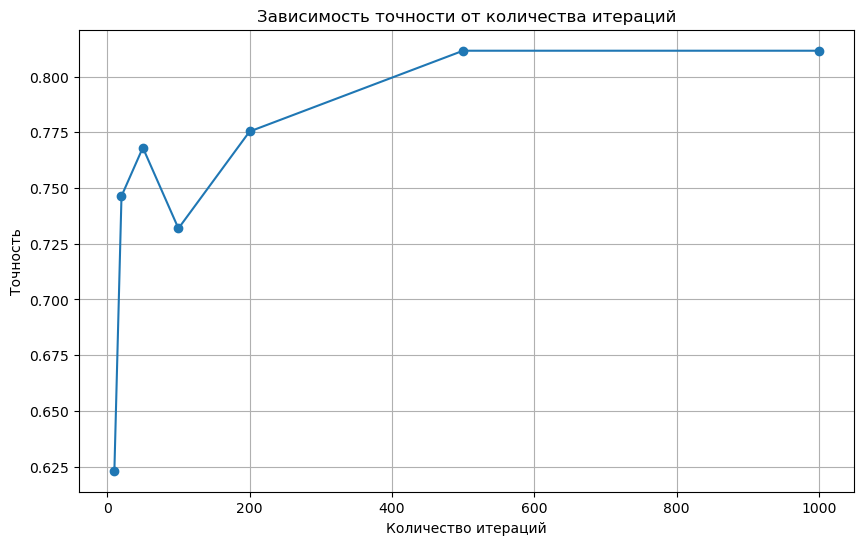

In [95]:
model = LogisticRegression(solver="lbfgs", max_iter=5000)
iterations = []
accuracies = []

max_iter_values = [10, 20, 50, 100, 200, 500, 1000]

warnings.filterwarnings("ignore")

# обучение модели и запись точности
for max_iter in max_iter_values:
    model.max_iter = max_iter
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    iterations.append(max_iter)
    accuracies.append(accuracy)
    
warnings.filterwarnings("default")

plt.figure(figsize=(10, 6))
plt.plot(iterations, accuracies, marker='o')
plt.title('Зависимость точности от количества итераций')
plt.xlabel('Количество итераций')
plt.ylabel('Точность')
plt.grid(True)
plt.show()


Определившись с выбором гиперпараметров, обучим нашу финальную версию модели логистической регрессии и рассмотрим её матрицу ошибок:

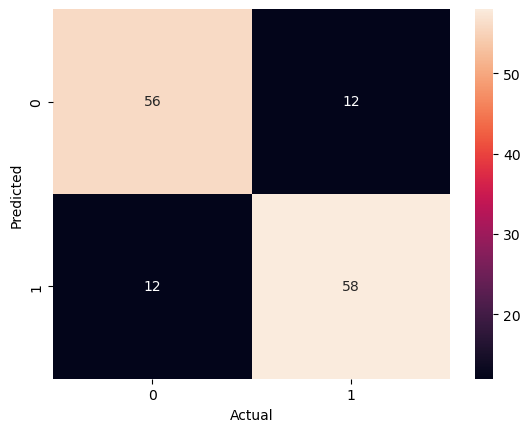

In [96]:
# создание модели логистической регрессии
model = LogisticRegression(solver = "lbfgs", max_iter = 5000)

# обучение модели
model.fit(X_train, y_train)

# получение прогнозов
y_pred = model.predict(X_test)

# оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

warnings.filterwarnings("ignore")
fig_mis = px.imshow(cm, text_auto=True)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
warnings.filterwarnings("default")


In [97]:
print('accuracy_score= {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('recall_score = {:.3f}'.format(recall_score(y_test, y_pred)))
print('precision_score = {:.3f}'.format(precision_score(y_test, y_pred)))

accuracy_score= 0.826
recall_score = 0.829
precision_score = 0.829


## Модель классификации ##

Так как наша таргетная переменная представляет собой бинарыный категориальный признак ("одобрен" или "не одобрен" кредит), то задачу предсказания таких ответов можно отнести к задаче классификации в машинном обучении.

Задача классификации – получение категориального ответа на основе набора признаков. 
Классификацию можно производить с помощью множества алгоритмов, но мы рассмотрим один из самых простых - метод случайного леса.

**Метод случайного леса (англ. random forest)** — алгоритм машинного обучения, заключающийся в использовании ансамбля решающих деревьев. 

Этот алгоритм основывается на том, что случайным образом строятся несколько деревьев решений, каждое из которых определяет значение класса таргетной категориальной переменной  (например, 0 или 1). После этого определяется предсказание: в условиях задачи классификации класс с наибольшим числом голосов от случайных деревье становится прогнозом алгоритма. 

Случайность в построении деревьев достигается таким образом: случайным образом выбираются с повторениями примеры из исходных данных, чтобы создать подвыборки для каждого дерева, далее эти подвыборки делятся на узлы дерева по одному на каждый, и так строится дерево решений различной глубины. 

По умолчанию в функции из библиотеки sklearn количество деревьев в лесу - 10.

![](https://serokell.io/files/vz/vz1f8191.Ensemble-of-decision-trees.png)

У функции ```RandomForestClassifier``` существует несколько параметров, но остановимся подробнее на трех основных:
- n_estimators (по умолчанию: 100): Этот параметр указывает количество деревьев в случайном лесе. Большее число деревьев может улучшить качество модели, но также может увеличить время обучения. В этом мы убедимся чуть позже.


- max_depth (по умолчанию: None): Этот параметр ограничивает максимальную глубину каждого дерева в случайном лесе. Если установлено значение None, деревья не будут ограничены по глубине.


In [98]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Model accuracy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy: 0.8623


Выведу основные метрики точности модели и проиллюстрирую ее работу на матрице ошибок:





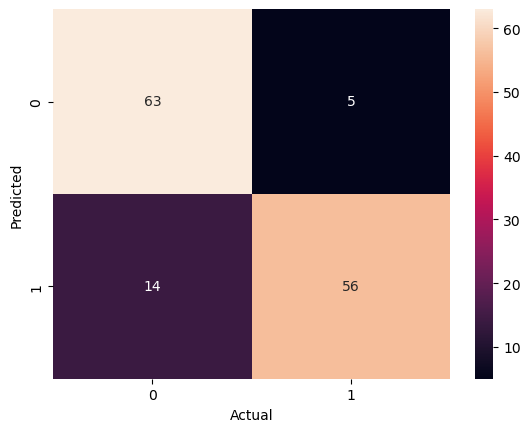

In [99]:
cm = confusion_matrix(y_test, y_pred)

warnings.filterwarnings("ignore")
fig_mis = px.imshow(cm, text_auto=True)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
warnings.filterwarnings("default")

In [100]:
print('accuracy_score= {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('recall_score = {:.3f}'.format(recall_score(y_test, y_pred)))
print('precision_score = {:.3f}'.format(precision_score(y_test, y_pred)))
print(f"Среднеквадратичная ошибка (MSE): {mse}")

accuracy_score= 0.862
recall_score = 0.800
precision_score = 0.918
Среднеквадратичная ошибка (MSE): 0.13768115942028986


Так же библиотека позволяет нам вывести "важность" каждого признака в предсказаниях деревьев:

In [101]:
features_importance = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
features_importance

name
A9     0.303131
A8     0.106889
A11    0.092417
A15    0.082871
A2     0.075874
A3     0.072177
A14    0.069325
A10    0.055627
A6     0.049274
A7     0.027653
A13    0.016236
A12    0.014481
A5     0.013110
A1     0.011151
A4     0.009785
dtype: float64

In [102]:
warnings.filterwarnings("ignore")
fig = px.bar(x=features_importance.index, y=features_importance)
fig.update_layout(
     title={
        "text": "Важность признаков",
        "x": 0.5
    },
    xaxis_title="Признак",
    yaxis_title="Показатель важности"
)
fig.update_xaxes(categoryorder='total ascending')  
fig.show()
warnings.filterwarnings("default")

Попробуем изменить настройки модели и проиллюстрируем изменения в ее работе : 

Будем обращать внимание на **precision**, так как, как было сказано выше, этот показатель особенно важен в задаче кредитного скоринга.

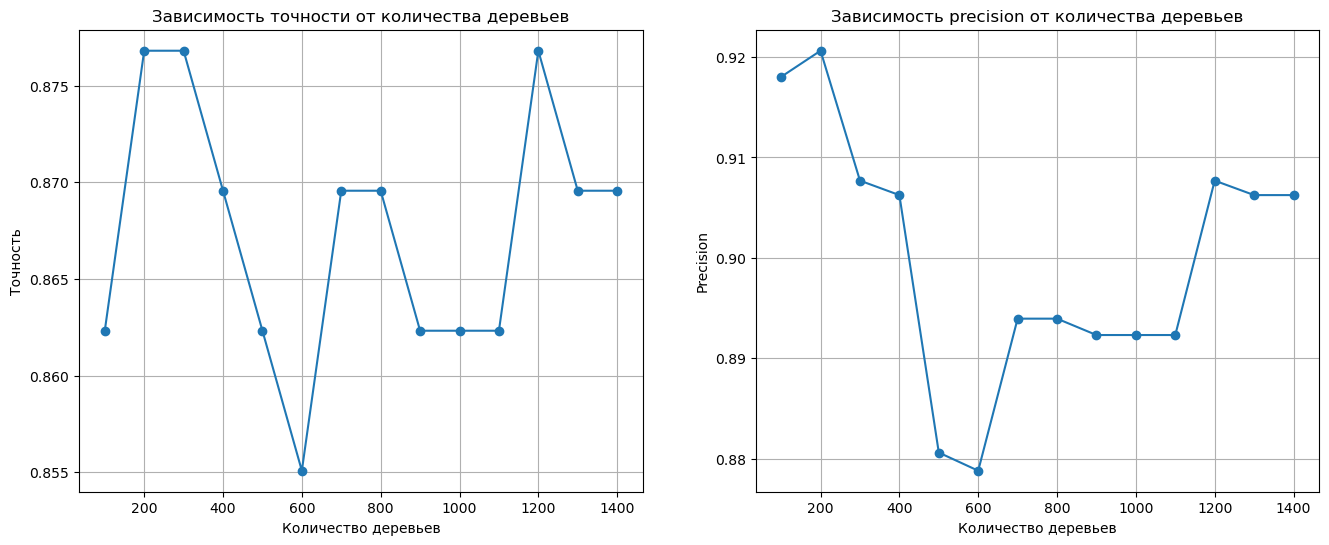

In [103]:
accuracy = []
precision = []
quantity=[]
max_accuracy = 0
max_precision = 0
max_quantity=0
for  i in range(100,1500, 100):
    quantity.append(i)
    rfc = RandomForestClassifier(random_state=0, n_estimators=i)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    cur_ac = accuracy_score(y_test, y_pred)
    cur_prec = precision_score(y_test, y_pred)
    accuracy.append(cur_ac)
    precision.append(cur_prec)
    if((cur_ac > max_accuracy) and (cur_prec>max_precision)):
        max_accuracy = cur_ac
        max_precision = cur_prec
        max_quantity = i

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))


axs[0].plot(quantity, accuracy, marker='o')
axs[0].set_title('Зависимость точности от количества деревьев')
axs[0].set_xlabel('Количество деревьев')
axs[0].set_ylabel('Точность')
axs[0].grid(True)

axs[1].plot(quantity, precision, marker='o')
axs[1].set_title('Зависимость precision от количества деревьев')
axs[1].set_xlabel('Количество деревьев')
axs[1].set_ylabel('Precision')
axs[1].grid(True)



plt.show()


На графике видно, что максимального значения presicion достигает на количестве деревьев 200. Это можно проинтерпретировать так: наш датасэт относительно небольшой, поэтому использование слишком большого количества деревьев нецелесообразно, так как большая вероятность тогоо, что слишком большое количество одинаковых подвыборок попадут в разные деревья, каждое из которых будет давать разное предсказание.Из-за этого точность модели может ухудшиться.

Однако, небольшое повышение количества деревьев (в нашем случае до 200), идет на пользу, так как теперь в алгоритме "больше мнений" от деревьев, что очевидно, может повысить количество правильных предсказаний.

Обучим модель на новом параметре и проиллюстриурем основные метрики для нее.

In [104]:
rfc2 = RandomForestClassifier(n_estimators=200, random_state=0)
rfc2.fit(X_train, y_train)
y_pred = rfc2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Model accuracy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy: 0.8768


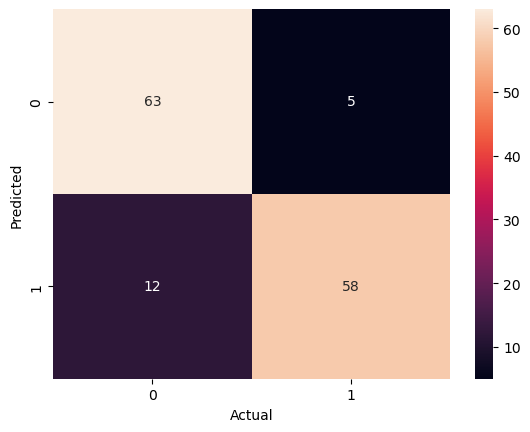

In [105]:
cm = confusion_matrix(y_test, y_pred)

warnings.filterwarnings("ignore")
fig_mis = px.imshow(cm, text_auto=True)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
warnings.filterwarnings("default")

In [106]:
print('accuracy_score= {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('recall_score = {:.3f}'.format(recall_score(y_test, y_pred)))
print('precision_score = {:.3f}'.format(precision_score(y_test, y_pred)))
print(f"Среднеквадратичная ошибка (MSE): {mse}")

accuracy_score= 0.877
recall_score = 0.829
precision_score = 0.921
Среднеквадратичная ошибка (MSE): 0.12318840579710146


In [107]:
features_importance = pd.Series(rfc2.feature_importances_, index=X_train.columns).sort_values(ascending=False)
features_importance

name
A9     0.290487
A8     0.104710
A11    0.101340
A15    0.087021
A3     0.076162
A2     0.074183
A14    0.067876
A10    0.054167
A6     0.051702
A7     0.027743
A13    0.015027
A12    0.013935
A5     0.012379
A1     0.011788
A4     0.011481
dtype: float64

In [108]:
warnings.filterwarnings("ignore")
fig = px.bar(x=features_importance.index, y=features_importance)
fig.update_layout(
     title={
        "text": "Важность признаков",
        "x": 0.5
    },
    xaxis_title="Признак",
    yaxis_title="Показатель важности"
)
fig.update_xaxes(categoryorder='total ascending')  
fig.show()
warnings.filterwarnings("default")

Заметим интересную деталь, что с увеличением количества деревьев, алгоритм стал считать признак A9 чуть менее важным. Иными словами, при увеличении "опрашиваемых" деревьев, повышается также качество анализа признаков в целом.